In [16]:
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns

In [17]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [18]:
#Import data
RT_data = 'X:\JOBS\~2019\QEJ19152\DATA ANALYSIS\RADIO TELEMETRY\HOME_RANGE_WORKING\EarlyWet2023\CTMM_input\RTpredLocs_LatLon_Subsample_IndivLocs_20230317.xlsx'
RT_data = pd.read_excel(RT_data)
RT_data['DateTime'] = pd.to_datetime(RT_data['DateTime'])

In [19]:
RT_data

,MetalBand,DateTime,TagID,X_Pred,Y_Pred,latitude,longitude,Type
0,027-48979,2021-02-08 23:59:00,8.0,431344.790052,-2.427262e+06,-21.948375,146.335122,Uncertain (radio tower estimate)
1,027-48979,2021-02-09 11:25:00,8.0,431355.630206,-2.427180e+06,-21.947637,146.335230,Uncertain (radio tower estimate)
2,027-48979,2021-02-10 16:15:00,8.0,431404.771804,-2.427098e+06,-21.946897,146.335710,Uncertain (radio tower estimate)
3,027-48979,2021-02-11 04:26:00,8.0,431314.807847,-2.427278e+06,-21.948518,146.334831,Uncertain (radio tower estimate)
4,027-48979,2021-02-12 13:00:00,8.0,431357.134617,-2.427274e+06,-21.948484,146.335241,Uncertain (radio tower estimate)
...,...,...,...,...,...,...,...,...
3872,027-52693,2022-02-15 13:40:00,NaN,NaN,NaN,-21.914993,146.272047,Drinking
3873,027-52694,2022-02-15 13:25:00,NaN,NaN,NaN,-21.914990,146.272042,Drinking
3874,027-52695,2022-02-15 13:47:00,NaN,NaN,NaN,-21.914992,146.272038,Drinking
3875,027-52696,2022-02-15 14:17:00,NaN,NaN,NaN,-21.914991,146.272044,Drinking


In [20]:
MetalBands = RT_data['MetalBand'].unique()
tag_capture_locs = []

for i, t in enumerate(MetalBands):
  #print(t) #tag ID
  #Details of first capture
  capture_dt = RT_data.loc[RT_data['MetalBand']==t, 'DateTime'].min()
  capture_x = RT_data.loc[(RT_data['MetalBand']==t)&(RT_data['DateTime']==capture_dt), 'longitude'].values
  capture_x = np.amin(capture_x)
  capture_y = RT_data.loc[(RT_data['MetalBand']==t)&(RT_data['DateTime']==capture_dt), 'latitude'].values
  capture_y = np.amin(capture_y)

  tag_capture_locs.append([t, capture_dt, capture_x, capture_y])

tag_capture_locs = pd.DataFrame(tag_capture_locs, columns=['MetalBand', 'capture_dt', 'capture_x', 'capture_y'])

In [15]:
#Checks
#tag_capture_locs.loc[tag_capture_locs['MetalBand']=='027-48996',:]

,MetalBand,capture_dt,capture_x,capture_y
45,027-48996,2021-03-15 09:22:00,146.2573,-21.9195


In [22]:
for index, row in RT_data.iterrows():
    tag = row['MetalBand']
    capture_x = tag_capture_locs.loc[tag_capture_locs['MetalBand']==tag,'capture_x']
    capture_y = tag_capture_locs.loc[tag_capture_locs['MetalBand']==tag,'capture_y']
    
    r_x = row['longitude']
    r_y = row['latitude']
    # print(tag)
    # print(capture_x.item())
    # print(capture_y.item())

    dist = haversine(capture_y, capture_x, r_y, r_x)
    RT_data.loc[index,'DistFromCapture'] = dist

  #print(capture_x)

In [ ]:
# Checks
#RT_data.iloc[:,:]
#RT_data.dtypes

In [27]:
dist_results = []

for i, t in enumerate(MetalBands):
  #Max distance moved from capture point
  MaxDist = RT_data.loc[RT_data['MetalBand']==t, 'DistFromCapture'].max()

  #Distance moved after n month
  capture_dt = tag_capture_locs.loc[tag_capture_locs['MetalBand']==t,'capture_dt']
  capture_dt = capture_dt.item()

  #2 Month Max
  end_dt = capture_dt + relativedelta(months=2)
  Two_mnth_max = RT_data.loc[(RT_data['MetalBand']==t) & (RT_data['DateTime'].between(capture_dt, end_dt)), 'DistFromCapture'].max()

  #2 to 6 Month Max
  start_dt = end_dt
  end_dt = start_dt + relativedelta(months=4)
  Two2Six_mnth_max = RT_data.loc[(RT_data['MetalBand']==t) & (RT_data['DateTime'].between(start_dt, end_dt)), 'DistFromCapture'].max()

  #Six month to 1 year
  start_dt = end_dt
  end_dt = start_dt + relativedelta(months=6)
  Six2Twelve_mnth_max = RT_data.loc[(RT_data['MetalBand']==t) & (RT_data['DateTime'].between(start_dt, end_dt)), 'DistFromCapture'].max()

  #1 year to 3 years
  start_dt = end_dt
  end_dt = start_dt + relativedelta(months=24)
  Twelve2thirtysix_mnth_max = RT_data.loc[(RT_data['MetalBand']==t) & (RT_data['DateTime'].between(start_dt, end_dt)), 'DistFromCapture'].max()

  dist_results.append([t, Two_mnth_max, Two2Six_mnth_max, Six2Twelve_mnth_max, Twelve2thirtysix_mnth_max, MaxDist])

dist_results = pd.DataFrame(dist_results, columns=['MetalBand', '0-2 months', '2-6 months', '6-12 months', '12-36 months', 'MaxDist'])

<AxesSubplot: >

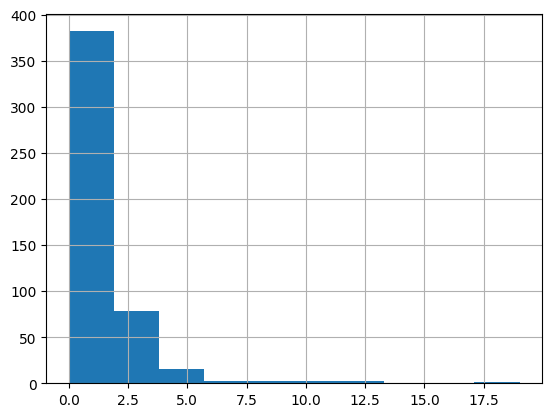

In [24]:
dist_results['MaxDist'].hist()

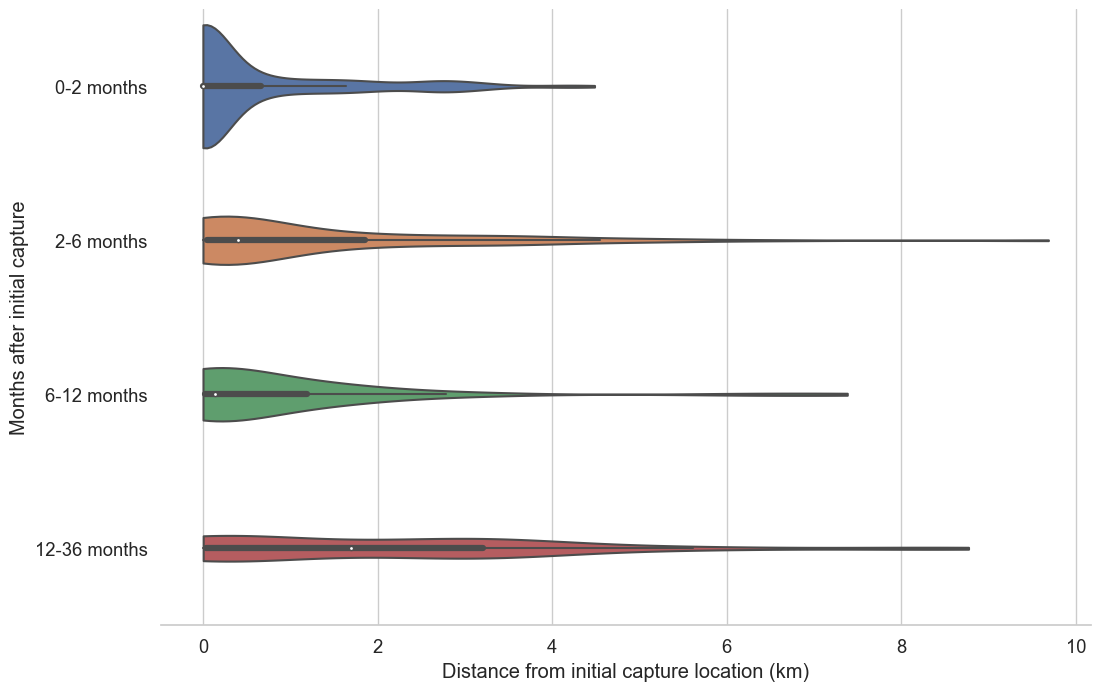

In [28]:
plot_data = dist_results[dist_results.MaxDist<10] #Filter to a maximum distance
plot_data = plot_data.drop(columns=['MetalBand', 'MaxDist'])

sns.set(font_scale=1.2)
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(12, 8))
sns.violinplot(data=plot_data, orient='h', cut=0, ax=ax)
ax.set_xlabel('Distance from initial capture location (km)')
ax.set_ylabel('Months after initial capture')
sns.despine(left=True)

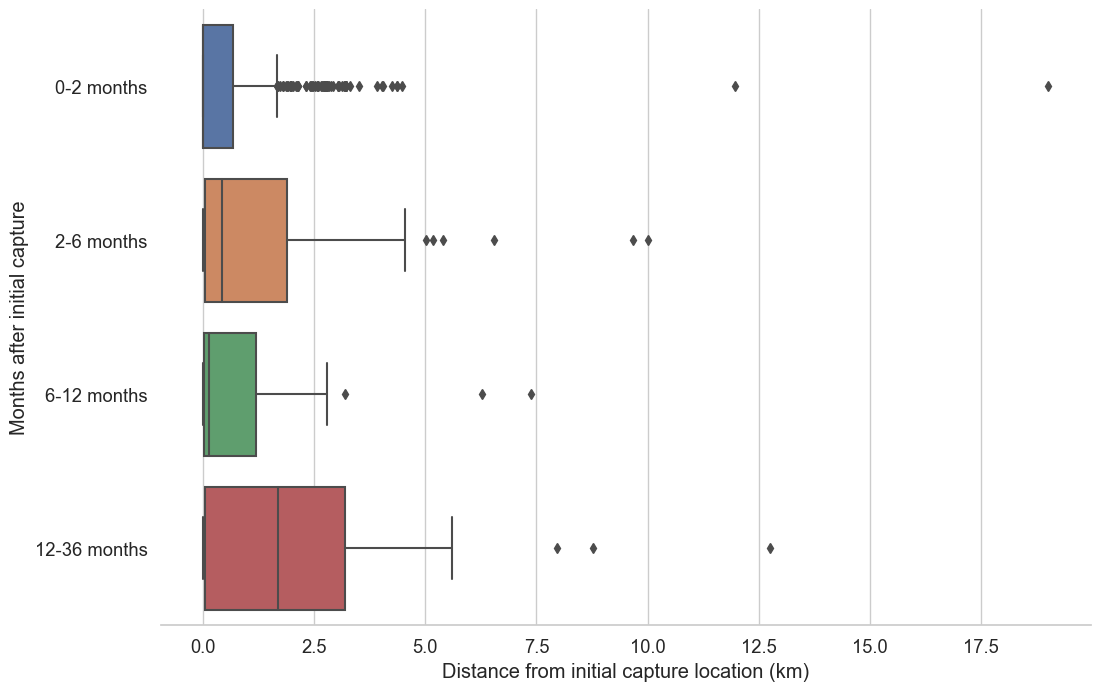

In [29]:
plot_data = dist_results[dist_results.MaxDist<30] #Filter to a maximum distance
plot_data = plot_data.drop(columns=['MetalBand', 'MaxDist'])

sns.set(font_scale=1.2)
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=plot_data, orient='h', ax=ax)
ax.set_xlabel('Distance from initial capture location (km)')
ax.set_ylabel('Months after initial capture')
sns.despine(left=True)

In [30]:
print(dist_results.mean())
print(dist_results.sem())

0-2 months      0.624493
2-6 months      1.315269
6-12 months     0.838488
12-36 months    2.193392
MaxDist         1.034928
dtype: float64
0-2 months      0.063292
2-6 months      0.195165
6-12 months     0.208873
12-36 months    0.367993
MaxDist         0.084482
dtype: float64


C:\Users\John\AppData\Local\Temp\ipykernel_29816\185387972.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dist_results.mean())
C:\Users\John\AppData\Local\Temp\ipykernel_29816\185387972.py:2: FutureWarning: The default value of numeric_only in DataFrame.sem is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(dist_results.sem())


In [46]:
RT_data

,MetalBand,DateTime,TagID,X_Pred,Y_Pred,latitude,longitude,Type,DistFromCapture
0,027-48979,2021-02-08 23:59:00,8.0,431344.790052,-2.427262e+06,-21.948375,146.335122,Uncertain (radio tower estimate),1.124097
1,027-48979,2021-02-09 11:25:00,8.0,431355.630206,-2.427180e+06,-21.947637,146.335230,Uncertain (radio tower estimate),1.128417
2,027-48979,2021-02-10 16:15:00,8.0,431404.771804,-2.427098e+06,-21.946897,146.335710,Uncertain (radio tower estimate),1.098081
3,027-48979,2021-02-11 04:26:00,8.0,431314.807847,-2.427278e+06,-21.948518,146.334831,Uncertain (radio tower estimate),1.153234
4,027-48979,2021-02-12 13:00:00,8.0,431357.134617,-2.427274e+06,-21.948484,146.335241,Uncertain (radio tower estimate),1.109099
...,...,...,...,...,...,...,...,...,...
3872,027-52693,2022-02-15 13:40:00,NaN,NaN,NaN,-21.914993,146.272047,Drinking,0.000000
3873,027-52694,2022-02-15 13:25:00,NaN,NaN,NaN,-21.914990,146.272042,Drinking,0.000000
3874,027-52695,2022-02-15 13:47:00,NaN,NaN,NaN,-21.914992,146.272038,Drinking,0.000000
3875,027-52696,2022-02-15 14:17:00,NaN,NaN,NaN,-21.914991,146.272044,Drinking,0.000000


In [37]:
Less_4km = RT_data.loc[RT_data['DistFromCapture']<4,:]
Prop_less_4km = Less_4km.shape[0]/RT_data.shape[0]
print(f'Proportion of sightings less than 4km from initial capture location = {Prop_less_4km}')

Proportion of sightings less than 4km from initial capture location = 0.9912303327314934


In [33]:
Less_4km = RT_data.loc[RT_data['DistFromCapture']<4,:]
Less_4km.shape[0]

3843

In [48]:
One2ThreeYear = dist_results.loc[dist_results['12-36 months'].notnull(),:]
More_4km = One2ThreeYear.loc[One2ThreeYear['12-36 months']>4,:]
print(More_4km.shape[0])
print(One2ThreeYear.shape[0])
print(f'Proportion of resightings more than 4km from initial capture location one to three years later = {More_4km.shape[0]/One2ThreeYear.shape[0]}')

6
50
Proportion of resightings more than 4km from initial capture location one to three years later = 0.12


In [49]:
dist_results[dist_results.MaxDist>6]

,MetalBand,0-2 months,2-6 months,6-12 months,12-36 months,MaxDist
0,027-48979,1.201719,NaN,NaN,8.768436,8.768436
3,027-48905,19.014141,NaN,NaN,0.643512,19.014141
62,027-52651,0.574843,6.547361,NaN,NaN,6.547361
78,027-52670,0.000000,10.006902,NaN,NaN,10.006902
87,027-55660,1.643046,NaN,7.379841,NaN,7.379841
156,027-48944,0.000000,NaN,0.023308,12.757601,12.757601
257,027-55570,11.964795,NaN,NaN,NaN,11.964795
262,027-55418,0.000000,NaN,6.268233,7.960967,7.960967
263,027-55603,0.000000,9.682861,NaN,NaN,9.682861


In [ ]:
dist_results